In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

## Read in Dataset

In [3]:
dataset_path = "C:/Users/wyiti/Documents/NUS/MedTech_Morphine/Morphine-22-23/ML/Datasets/01-02-2023/"
os.chdir(dataset_path)

In [4]:
os.listdir()

['anomalous_gps_data.csv',
 'anomalous_mpu6050_data.csv',
 'healthy_gps_data.csv',
 'healthy_mpu6050_data.csv',
 'jump_data_1',
 'normal_data_1']

In [5]:
healthy_df = pd.read_csv(dataset_path + 'healthy_mpu6050_data.csv').loc[:, 'accounter':'timeDifference']
anomalous_df = pd.read_csv(dataset_path + 'anomalous_mpu6050_data.csv').loc[:, 'accounter':'timeDifference']

In [6]:
raw_healthy_input_df = healthy_df.loc[:, 'Ax':'gz']
raw_anomalous_input_df = anomalous_df.loc[:, 'Ax':'gz']
#display(raw_healthy_input_df)
#display(raw_anomalous_input_df)

raw_healthy_input = raw_healthy_input_df.values
raw_anomalous_input = raw_anomalous_input_df.values

print(raw_healthy_input.shape)
print(raw_anomalous_input.shape)

(79680, 6)
(440, 6)


## Normalise Inputs

In [7]:
scaler = MinMaxScaler()
scaler.fit(np.concatenate([raw_healthy_input, raw_anomalous_input]))

normalised_healthy_input = scaler.transform(raw_healthy_input)
normalised_anomalous_input = scaler.transform(raw_anomalous_input)

## Split Healthy Datasets into Train and Validation

In [8]:
healthy_input_label = np.zeros(shape = (normalised_healthy_input.shape[0], 1))
x_train, x_validate, y_train, y_validate = train_test_split(normalised_healthy_input, healthy_input_label, test_size=0.2, random_state=42)

In [9]:
print(x_train.shape)
print(x_validate.shape)

(63744, 6)
(15936, 6)


## Visualise Input Space using PCA

In [10]:
normalised_input = np.concatenate([normalised_healthy_input, raw_anomalous_input])

In [11]:
input_pca = PCA(n_components=2)
input_pca.fit(normalised_input)
transformed_input = input_pca.transform(normalised_input)
transformed_healthy_input = input_pca.transform(normalised_healthy_input)
transformed_anomalous_input = input_pca.transform(raw_anomalous_input)
print(input_pca.explained_variance_ratio_)

[0.49874029 0.19540035]


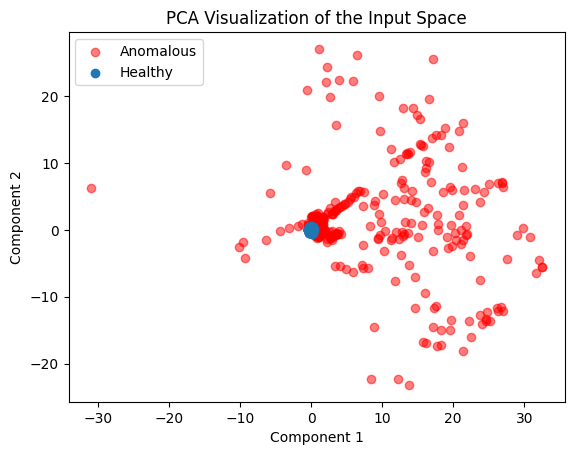

In [12]:
# visualise the graph
plt.scatter(transformed_anomalous_input[:,0], transformed_anomalous_input[:,1], label = 'Anomalous', color = 'red', alpha = 0.5)
plt.scatter(transformed_healthy_input[:,0], transformed_healthy_input[:,1], label = 'Healthy')
plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Visualization of the Input Space')
plt.show()

## Build Autoencoder Model

In [22]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            Dense(20, activation = 'relu'),
            Dense(2, activation = 'relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            Dense(20, activation = 'relu'),
            Dense(6, activation = 'sigmoid')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mae')

In [23]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)
history = autoencoder.fit(x_train, x_train, 
          epochs=1000, 
          batch_size=512,
          validation_data=(x_validate, x_validate),
          shuffle=True,
          callbacks = [early_stopping])

Epoch 1/1000
125/125 [==============================] - 1s 2ms/step - loss: 0.0962 - val_loss: 0.0774
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0752 - val_loss: 0.0722
Epoch 3/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0572
Epoch 4/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0497 - val_loss: 0.0444
Epoch 5/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0427 - val_loss: 0.0417
Epoch 6/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0410 - val_loss: 0.0405
Epoch 7/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0400 - val_loss: 0.0397
Epoch 8/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0395 - val_loss: 0.0393
Epoch 9/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0391 - val_loss: 0.0390
Epoch 10/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.038

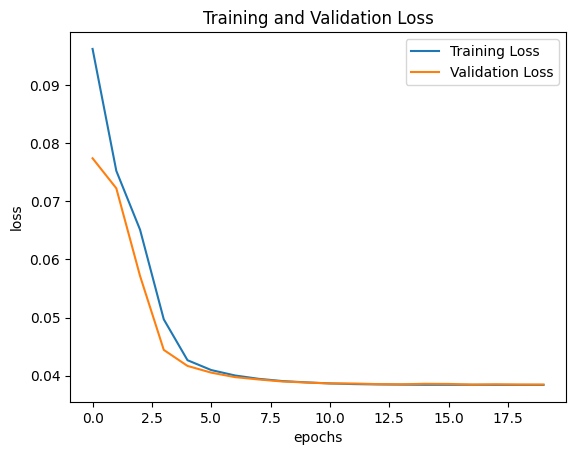

In [24]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## Prediction

In [31]:
healthy_predicted = autoencoder(normalised_healthy_input)
healthy_loss = tf.keras.losses.mae(healthy_predicted, normalised_healthy_input)

In [32]:
anomalous_predicted = autoencoder(normalised_anomalous_input)
anomalous_loss = tf.keras.losses.mae(anomalous_predicted, normalised_anomalous_input)

## Analysis - Reconstruction Loss

C:\Users\wyiti\AppData\Local\Temp\ipykernel_16708\4163287454.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(healthy_loss, label = 'Healthy')
C:\Users\wyiti\AppData\Local\Temp\ipykernel_16708\4163287454.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(anomalous_loss, label = 'Anomalous', 

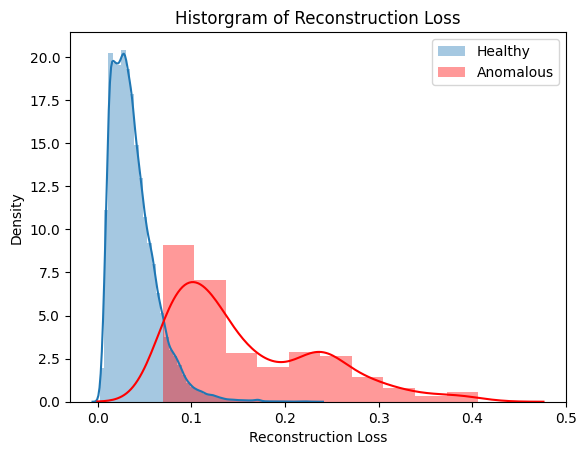

In [36]:
sns.distplot(healthy_loss, label = 'Healthy')
sns.distplot(anomalous_loss, label = 'Anomalous', color = 'red')
plt.legend()
plt.title('Historgram of Reconstruction Loss')
plt.xlabel('Reconstruction Loss')
plt.show()

### Finding the best threshold

In [43]:
min_threshold = min(np.min(healthy_loss), np.min(anomalous_loss))
max_threshold = max(np.max(healthy_loss), np.max(anomalous_loss))
threshold_list = np.linspace(min_threshold, max_threshold, 1000)

In [44]:
#recall = TP / TP + FN
#precision = TP + / TP + FP

recall_list = []
precision_list = []

for threshold in threshold_list[:-1]:
    tp = np.sum(anomalous_loss > threshold)
    fn = np.sum(anomalous_loss <= threshold)
    tn = np.sum(healthy_loss <= threshold)
    fp = np.sum(healthy_loss > threshold)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    recall_list.append(recall)
    precision_list.append(precision)

In [73]:
diff = [abs(precision_list[i] - recall_list[i]) for i in range(len(precision_list))]
best_threshold_index = np.where(diff == np.min(diff))[0][0]
best_threshold = threshold_list[best_threshold_index]
best_recall = recall_list[best_threshold_index]
best_precision = precision_list[best_threshold_index]

print('Threshold Information')
print('---------------------')
print(f'Best Threshold: {round(best_threshold, 4)}')
print(f'Recall: {round(best_recall, 4)}')
print(f'Precision: {round(best_precision, 4)}')

Threshold Information
---------------------
Best Threshold: 0.1498
Recall: 0.4364
Precision: 0.4364


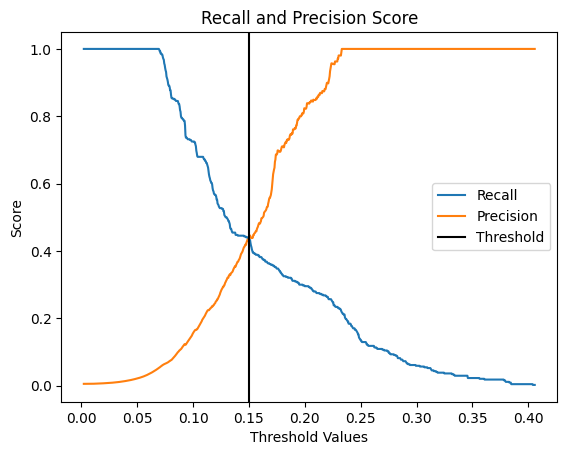

In [77]:
plt.plot(threshold_list[:-1], recall_list, label = 'Recall')
plt.plot(threshold_list[:-1], precision_list, label = 'Precision')
plt.axvline(x = best_threshold, color = 'black', label = 'Threshold')
plt.legend()
plt.title('Recall and Precision Score')
plt.xlabel('Threshold Values')
plt.ylabel('Score')
plt.show()

C:\Users\wyiti\AppData\Local\Temp\ipykernel_16708\2977236290.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(healthy_loss, label = 'Healthy')
C:\Users\wyiti\AppData\Local\Temp\ipykernel_16708\2977236290.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(anomalous_loss, label = 'Anomalous', 

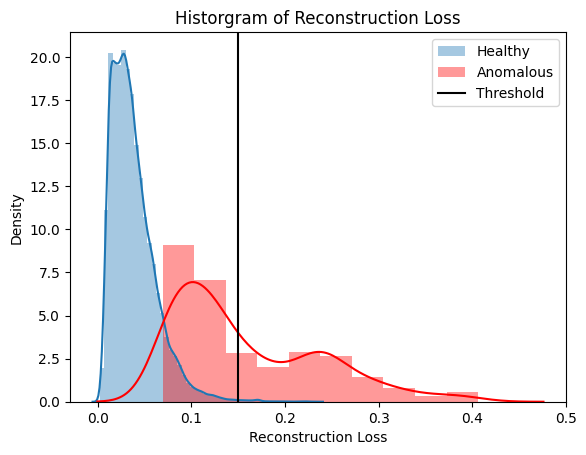

In [78]:
sns.distplot(healthy_loss, label = 'Healthy')
sns.distplot(anomalous_loss, label = 'Anomalous', color = 'red')
plt.axvline(x = best_threshold, color = 'black', label = 'Threshold')
plt.legend()
plt.title('Historgram of Reconstruction Loss')
plt.xlabel('Reconstruction Loss')
plt.show()